# Multiple Correspondance Analysis (MCA) of Kinase Targets in *Mycobacterium tuberculosis*

This analysis with Multiple Correspondence Analysis (MCA) to evaluate if there are groups of genes targeted by a simmilar group of kinases, as well as determining simmilarities between the kinases based on which genes they target. 

## 1. Import Needed Libraries

In [1]:
# Standard Library Imports
import os
from typing import Callable
import warnings

# External Imports
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import prince
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.exceptions import ConvergenceWarning

# Local Imports

/tmp/ipykernel_13115/1254425941.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 2. Load and Preprocess Data

Data for the phosphorylation sites from:  
Frando, A., Boradia, V., Gritsenko, M. et al. The Mycobacterium tuberculosis protein O-phosphorylation landscape. Nat Microbiol 8, 548–561 (2023). [https://doi.org/10.1038/s41564-022-01313-7](https://www.nature.com/articles/s41564-022-01313-7)

Data has sheets for each of the kinases studied, which includes which columns for:  
 - Mutant: Whether the phosphorylation was observed based on an OE or LOF mutant
 - Peptide: Peptide tag from the Mass Spectrometry Experiments
 - Rv Number: The locus tag for a gene
 - Gene Name: The name for the gene (Blank if no name assigned)
 - Phosphosite: Where on the gene the kinase phosphorylated, in the form of \<Rv Number\>_\<AA Number\>_\<AA Residue\>
 - Quantification of the amount of phosphorylation and significance level
 - Indirect?: Whether the phosphorylation effect is considered to be indirect

In [2]:
# Read the Mtb genes data to get a list of all genes
gene_info = pd.read_csv(os.path.join("..", "data", "Mtb_genes.csv"))
gene_list = pd.Index(gene_info["Locus"].values)
kinase_list = ["PknB","PknD","PknE","PknF","PknG","PknH","PknI","PknJ","PknK","PknL"]

direct_phos_df = pd.DataFrame(0, index=gene_list, columns = kinase_list)
total_phos_df = pd.DataFrame(0, index=gene_list, columns = kinase_list)

In [3]:
# Create a dictionary of name conversions, to convert the Frando genes to Mycobrowser genes
name_conv_dict = {"Rv1155a": "Rv1155", "Rv2975a":"Rv2975c"}

# For each kinase, read the correct sheet and get a list of the phosphorylated genes
for kinase in kinase_list:
    df = pd.read_excel(os.path.join("..","data", "frando_phosphosite_data.xlsx"), 
                       sheet_name=kinase).replace(name_conv_dict)
    direct_df = df[~(df["Indirect?"]=="Indirect")]

    total_phos_df.loc[df["Rv Number"], kinase] = 1
    direct_phos_df.loc[direct_df["Rv Number"], kinase] = 1

# Now only keep the rows with at least 1 phosphorylation (TODO: VALID?)
direct_phos_df = direct_phos_df[direct_phos_df.sum(axis=1)>0]

## 3. Perform MCA Decomposition
Use the Prince package to perform MCA on the kinase targeting data

### 3a. Fit initial MCA

In [4]:
# MCA
mca_res = prince.MCA(n_components = 10, one_hot=False, check_input=True)
mca_res = mca_res.fit(direct_phos_df)

### 3b. Plot Cumulative % of Variance explained

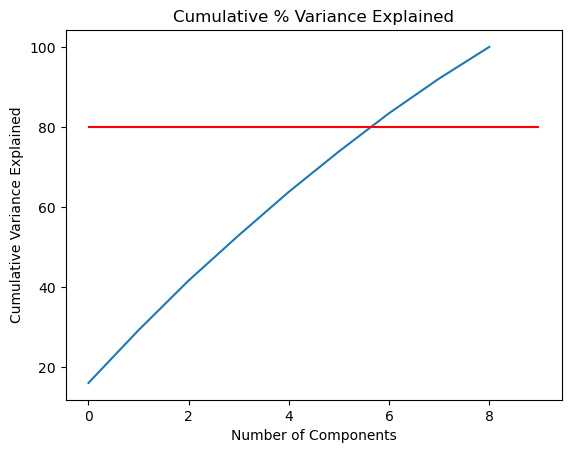

In [5]:
fig, ax = plt.subplots()

# Convert cumulative % of Variance explained to float
eig_sum = mca_res.eigenvalues_summary
eig_sum["cumulative explained"] = eig_sum["% of variance (cumulative)"].str.rstrip("%").astype(float)

# Plot the results
sns.lineplot(eig_sum, x=mca_res.eigenvalues_summary.index, y="cumulative explained")
ax.set_title("Cumulative % Variance Explained")
ax.set_ylabel("Cumulative Variance Explained")
ax.set_xlabel("Number of Components")

ax.hlines(y=80, xmin=0, xmax=9, colors="r")


As can be seen in the above graph, with 6 components, >80% of the variance can be explained, so 6 components will be used for the remainder of the analysis. 

In [6]:
# Set N_COMPONENTS based on above graph
N_COMPONENTS=6

# Compute the final MCA with this number of components
mca_final = prince.MCA(n_components = N_COMPONENTS, one_hot=False, check_input=True)
mca_final = mca_final.fit(direct_phos_df)

### 3c. Plot the MCA results

In [7]:
mca_final.plot(direct_phos_df, x_component=0, y_component=1,
            show_column_markers=True, 
            show_column_labels=True, 
            show_row_labels=False)

alt.LayerChart(...)

## 4. Kinase (Column) Clustering

Using agglomerative hierarchical clustering to find which kinases phosphorylate simmilar genes. 

In [8]:
# Get the column coordinates from the MCA
col_coords = mca_final.column_coordinates(direct_phos_df)
col_coords

,0,1,2,3,4,5
PknB,1.201468,0.544654,0.163060,-0.143808,0.361197,0.014656
PknD,0.775804,-0.275184,-1.279025,0.491561,-0.066846,0.458367
PknE,0.084233,-0.327345,0.081682,-0.169812,-0.307487,-0.882499
PknF,0.046671,-0.653266,0.351213,-0.431783,0.193133,0.445644
PknG,2.404927,2.024765,2.284303,0.318991,-2.128460,1.193891
PknH,0.673534,-0.140027,-0.310360,-0.170004,-0.668202,-0.390774
PknI,1.284570,0.432167,0.448261,-0.246412,0.737254,-0.452070
PknJ,1.858708,0.955008,0.507087,0.301869,2.937207,-0.984141
PknK,-0.448323,0.625557,-0.270308,-0.422094,0.028918,0.077434
PknL,-0.398259,0.004007,0.232576,0.674599,0.032294,0.018935


In [9]:
# Function from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

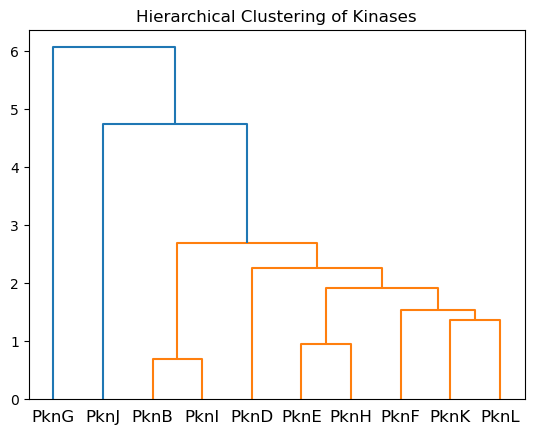

In [10]:
# Plot the kinase dendrogram 
agg_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

agg_cluster = agg_cluster.fit(col_coords)
plt.title("Hierarchical Clustering of Kinases")
plot_dendrogram(agg_cluster, labels = col_coords.index)

## 5. Gene (row) Clustering

Now the genes will be clustered to determine which genes are phosphorylated by simmilar groups of kinases. To find the best clustering, KMeans, DBSCAN, and OPTICS will be evaluated (with their respective hyperparameters) using the silhouette score. To improve the search speed the optuna library implementing a Parzen Tree structured estimator will be used to find the optimal model, and hyperparameters. 

In [11]:
# Get the row coordinates
row_coords = mca_final.row_coordinates(direct_phos_df)
row_coords

,0,1,2,3,4,5
Rv0005,-0.056413,-0.080744,0.001587,-0.186079,-0.224919,0.085268
Rv0036c,-0.800495,1.233993,-0.550045,-0.899476,0.062864,0.174627
Rv0013,-0.319467,-0.173122,0.201027,-0.185976,-0.028881,-0.191963
Rv0015c,0.571023,0.108093,-0.127782,0.157814,1.020718,-0.325594
Rv0020c,1.336173,0.629336,0.449401,0.043282,0.243259,-0.112884
...,...,...,...,...,...,...
Rv3921c,-0.159124,-0.642160,0.451385,0.051857,-0.059463,-0.314159
Rv3923c,-0.313886,-0.640374,0.593970,0.258719,0.245027,0.523854
Rv0491,-0.313886,-0.640374,0.593970,0.258719,0.245027,0.523854
Rv1079,-0.015050,-0.193742,0.034513,-0.221236,-0.313624,-0.329823


In [12]:
# Define a objective function to be optimized, this will be the silhouette score
def objective(trial):#, score_method:Callable = silhouette_score, drop_noise:bool = False):
    # Suggest a clustering method
    cluster_method = trial.suggest_categorical('cluster-method', ["KMeans", "DBSCAN", "OPTICS", "Agglomerative"])
    # Depending on which method is chosen, choose remaining hyperparameters and create the clustering object
    match cluster_method:
        case "KMeans":
            n_clusters = trial.suggest_int("kmeans_n_estimators", low=5, high=500)
            clusterer = KMeans(n_clusters=n_clusters)
        case "DBSCAN":
            eps = trial.suggest_float("dbscan_eps", low=0.005, high=10)
            min_samples = trial.suggest_int("min_dbscan_samples", low=2, high = 50)
            clusterer = DBSCAN(eps=eps, min_samples=min_samples)
        case "OPTICS":
            min_samples = trial.suggest_int("optics_min_samples", low=2, high=50)
            clusterer = OPTICS(min_samples = min_samples)
        case "Agglomerative":
            n_clusters = trial.suggest_int("agglomerative_n_clusters", low=5, high=500)
            linkage = trial.suggest_categorical("agglomerative_linkage", ["ward", "complete", "average", "single"])
            clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        case _:
            raise ValueError("Invalid Cluster Method")
    clusters = clusterer.fit_predict(row_coords)
    if len(np.unique(clusters))<2: # If only one cluster, silhouette score doesn't work, return minimum value
        return -1
    # print(cluster_method)
    # print(f"Params: {clusterer.get_params}")
    # print(f"Clusters: {np.unique(clusterer.fit_predict(row_coords))}")
    return silhouette_score(row_coords, clusters)
    # if not drop_noise:
    #     return silhouette_score(row_coords, clusterer.fit_predict(row_coords))
    # clusters = clusterer.fit_predict(row_coords)
    # if -1 in clusters: # This is the noise cluster
    #     filtered_data = row_coords.values[np.squeeze(clusters)!=-1,...]
    #     filtered_clusters = clusters[clusters!=-1]
    #     return silhouette_score(filtered_data, filtered_clusters)
    # return silhouette_score(row_coords, clusters)
        

In [27]:
def objective(trial):#, score_method:Callable = silhouette_score, drop_noise:bool = False):
    n_clusters = trial.suggest_int("kmeans_n_estimators", low=5, high=1000)
    clusterer = KMeans(n_clusters=n_clusters)
    clusters = clusterer.fit_predict(row_coords)
    return silhouette_score(row_coords, clusters)

In [28]:
study = optuna.create_study(study_name="Cluster Optimization", direction="maximize", sampler = optuna.samplers.TPESampler(n_startup_trials=100, multivariate=True))
optuna.logging.set_verbosity(optuna.logging.ERROR)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    study.optimize(objective, n_trials=1000, show_progress_bar=True)

/home/bgriebel/miniforge3/envs/kinase-mca/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(f"The best parameters were found in trial {study.best_trial.number} and were {study.best_params}")

In [ ]:
trials = study.trials_dataframe()
sns.scatterplot(data=trials, x="params_kmeans_n_estimators", y="value", hue="datetime_start")